In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from stock import *
from sklearn.metrics import mean_absolute_error, mean_squared_error

import mplfinance as mpf

In [10]:
class StockModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2, output_size=4, n_futures=8):
        super(StockModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size * n_futures)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = x.view(-1, n_futures, output_size)
        return x

model = StockModel()

In [11]:
input_size=5
hidden_size=64
num_layers=1
output_size=4
n_futures=8

In [12]:
def process_data(data, n_windows: int = 64, n_futures = 1):
    n_columns = len(data[0])
    size = len(data)
    
    X = np.zeros((size - n_windows, n_windows, n_columns))
    y = np.zeros((size - n_windows, n_futures, n_columns - 1))
    
    for i in range(size - n_windows - n_futures):
        X[i] = data[i : i + n_windows]
        y[i] = data[i + n_windows : i + n_windows + n_futures, 0: n_columns - 1]

    return X, y

In [13]:
data = load_raw_stock_data("AAPL")
data = data.pct_change()
data = data.dropna()
data = data.to_numpy()

In [14]:
X, y = process_data(data, n_futures=8)
batch_size = 64

dataset = StockDataset(X, y)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 1 - 0.8])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [16]:
n_epochs = 50
model.train()

for epoch in range(n_epochs):
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if epoch % 10 == 0:
        print(f"EPOCH {epoch+1}/{n_epochs}: Loss - {epoch_loss/ len(train_loader):.10f}")

EPOCH 1/50: Loss - 0.0036147888
EPOCH 11/50: Loss - 0.0007136782
EPOCH 21/50: Loss - 0.0007038890
EPOCH 31/50: Loss - 0.0006914801
EPOCH 41/50: Loss - 0.0006894955


In [45]:
raw_data = load_raw_stock_data("AAPL").to_numpy()
raw_data = raw_data[-200:-200+64]
raw_data = raw_data.reshape(1, 64, 5)

x = torch.tensor(raw_data, dtype=torch.float32)
y_test = model(x).detach().numpy()

y_pred = np.zeros((64 + 8, 4))
raw_data = raw_data.reshape(64, 5)

for i in range(64):
    y_pred[i] = raw_data[i][:4]

y_test = y_test.reshape(8, 4)

for i in range(8):
    for j in range(4):
        y_pred[i+64][j] = y_pred[i + 64 - 1][j] + (y_test[i][j] * y_pred[i+64-1][j])

<Figure size 600x600 with 0 Axes>

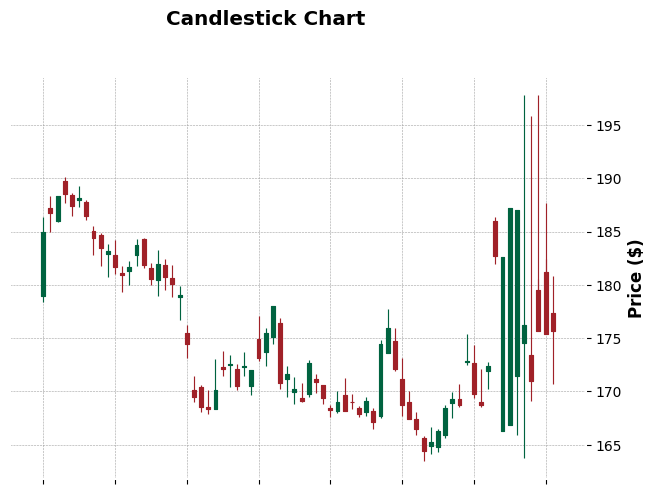

In [46]:
df = pd.DataFrame(y_pred, columns=['Open', 'High', 'Low', 'Close'])
df.index = pd.date_range("2023-01-01", periods=len(df), freq="D")

plt.figure(figsize=(6,6))

mpf.plot(
    df,
    type='candle',
    style='charles',
    title="Candlestick Chart",
    ylabel="Price ($)",
    datetime_format='',
    # addplot=mpf.make_addplot(ohlc_data['Close'], color='blue', linestyle='--'),
    volume=False
)

## Conclusion

As you can see the prediction get affected heavily because of the noise